Long Range CNOT teleportation using dynamic circuits

Step 1: Map the problem to circuits and operators

In [17]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_dynamic_CNOT_circuit(num_qubit):
    """
    (1) 1D chain of nearest neighbors
    (2) 0th qubit is the control, and the last qubit (num_qubit-1) is the target
    (3) The control qubit starts in the + state
    """
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name="cr1") # The parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2") # The parity-controlled Z gate
    cr3 = ClassicalRegister(2, name="cr3") # For the final measurements on the control and target qubits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    # Initialize the control qubit
    qc.h(0)
    qc.barrier()

    # Entangle the contorl qubit and the first ancilla qubit
    qc.cx(0,1)

    # Create Bell pairs on ancilla qubits
    # The first ancilla qubit in index 1
    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)

    # Prepare Bell pairs on staggered ancilla and data qubits
    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)
    for i in range(1, num_ancilla_pair+2):
        qc.h(2*i-1)

    # Measurement on alternating ancilla qubits starting with the first one
    # Keep track of the parity for eventual conditional Z gate
    for i in range(1, num_ancilla_pair+2):
        qc.measure(2*i - 1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1])
        else:
            parity_control = expr.bit_xor(cr2[i-1], parity_control)

    # Measurement on staggered alternating ancilla qubits starting with the second
    # Keep track of the parity of eventual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)

    with qc.if_test(parity_control):
        qc.z(0)

    with qc.if_test(parity_target):
        qc.x(-1)

    # Final measurements on the control and target qubits
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])

    return qc

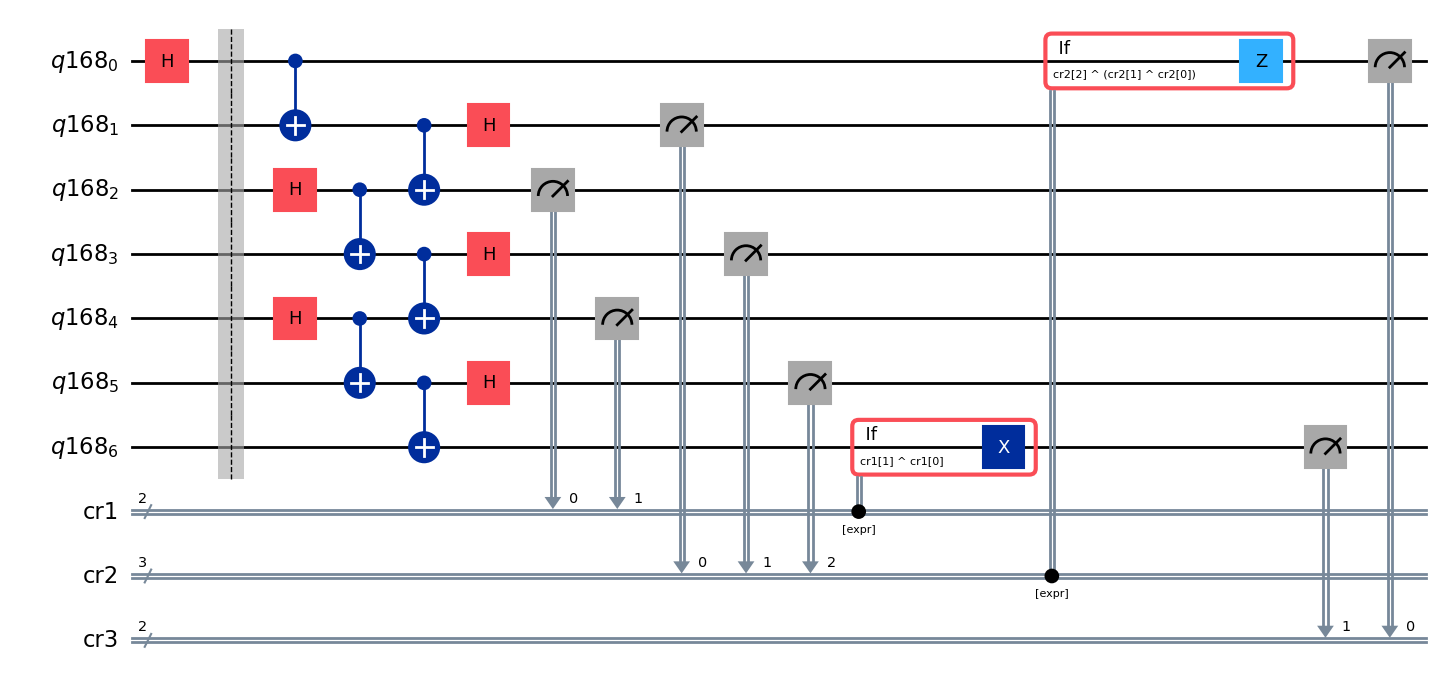

In [18]:
qc = get_dynamic_CNOT_circuit(num_qubit=7)
qc.draw(output='mpl')

In [19]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

Step 2: Optimize the problem for quantum execution

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend(name='ibm_brisbane')
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

Step 3:  Execute the circuit

In [22]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

cvkamc9p7drg008mbhag


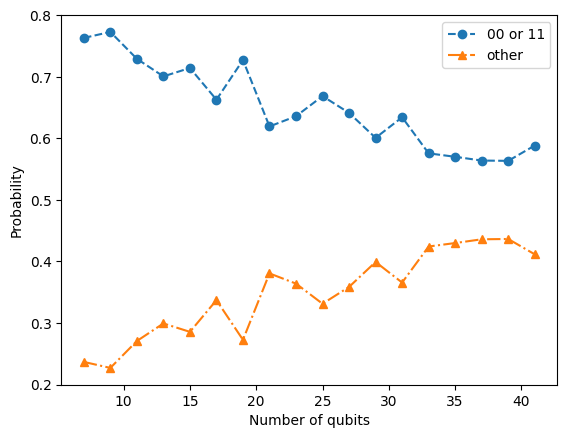

In [23]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'cvkamc9p7drg008mbhag' # Cusco, documentation provider, max_qubit=41, new image

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(0, len(qc_list)):
    data = result[i].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts['00'] + counts['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label ='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()